# Introducing the Keras Functional API

## Learning objectives
  1. Understand embeddings and how to create them with the preprocessing layer.
  2. Understand Deep and Wide models and when to use them.
  3. Understand the Keras functional API and how to build a deep and wide model with it.

## Introduction

In the last notebook, we learned about the Keras Sequential API. The [Keras Functional API](https://www.tensorflow.org/guide/keras#functional_api) provides an alternate way of building models which is more flexible. With the Functional API, we can build models with more complex topologies, multiple input or output layers, shared layers or non-sequential data flows (e.g. residual layers).

In this notebook we'll use what we learned about preprocessing layers to build a Wide & Deep model. Recall, that the idea behind Wide & Deep models is to join the two methods of learning through memorization and generalization by making a wide linear model and a deep learning model to accommodate both. You can have a look at the original research paper here: [Wide & Deep Learning for Recommender Systems](https://arxiv.org/abs/1606.07792).

<img src='assets/wide_deep.png' width='80%'>
<sup>(image: https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html)</sup>

The Wide part of the model is associated with the memory element. In this case, we train a linear model with a wide set of crossed features and learn the correlation of this related data with the assigned label. The Deep part of the model is associated with the generalization element where we use embedding vectors for features. The best embeddings are then learned through the training process. While both of these methods can work well alone, Wide & Deep models excel by combining these techniques together. 

Start by importing the necessary libraries for this lab.

In [16]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import (
    CategoryEncoding,
    Concatenate,
    Dense,
    Discretization,
    Embedding,
    Flatten,
    Input,
)
from tensorflow.keras.layers.experimental.preprocessing import HashedCrossing

print(tf.__version__)

2.10.0


In [17]:
%matplotlib inline

## Load raw data 

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence. Those files have been saved into `../data`.

In [3]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter 123590 Sep 14 11:04 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579055 Sep 14 11:04 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 123114 Sep 14 11:04 ../data/taxi-valid.csv


## Use tf.data to read the CSV files

We wrote these functions for reading data from the csv files above in the [previous notebook](2_dataset_api.ipynb). For this lab we will also include some additional engineered features in our model. In particular, we will compute the difference in latitude and longitude, as well as the Euclidean distance between the pick-up and drop-off locations. We can accomplish this by adding these new features to the features dictionary with the function `add_engineered_features` below. 

Note that we include a call to this function when collecting our features dict and labels in the `features_and_labels` function below as well. 

In [18]:
CSV_COLUMNS = [
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "key",
]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], ["na"], [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]
UNWANTED_COLS = ["pickup_datetime", "key"]


def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data

    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def create_dataset(pattern, batch_size=1, mode="eval"):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS
    )

    dataset = dataset.map(features_and_labels)

    if mode == "train":
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## Build a Wide and Deep model in Keras

To build a wide-and-deep network, we connect the sparse (i.e. wide) features directly to the output node, but pass the dense (i.e. deep) features through a set of fully connected layers. Here’s that model architecture looks using the Functional API.

First, we'll create our input columns using [tf.keras.layers.Input](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Input).

In [19]:
INPUT_COLS = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
]

# TODO
inputs = {
    colname: Input(name=colname, shape=(1,), dtype="float32")
    for colname in INPUT_COLS
}

Then, we can connect each layers one by one, and define Wide and Deep model.

In [20]:
dnn_hidden_units = [32, 8]
NBUCKETS = 16

latbuckets = np.linspace(start=38.0, stop=42.0, num=NBUCKETS).tolist()
lonbuckets = np.linspace(start=-76.0, stop=-72.0, num=NBUCKETS).tolist()

# Bucketization with Discretization layer
plon = Discretization(lonbuckets, name="plon_bkt")(inputs["pickup_longitude"])
plat = Discretization(latbuckets, name="plat_bkt")(inputs["pickup_latitude"])
dlon = Discretization(lonbuckets, name="dlon_bkt")(inputs["dropoff_longitude"])
dlat = Discretization(latbuckets, name="dlat_bkt")(inputs["dropoff_latitude"])

# Feature Cross with HashedCrossing layer
p_fc = HashedCrossing(num_bins=NBUCKETS * NBUCKETS, name="p_fc")((plon, plat))
d_fc = HashedCrossing(num_bins=NBUCKETS * NBUCKETS, name="d_fc")((dlon, dlat))
pd_fc = HashedCrossing(num_bins=NBUCKETS**4, name="pd_fc")((p_fc, d_fc))

# Embedding with Embedding layer
pd_embed = Embedding(input_dim=NBUCKETS**4, output_dim=10, name="pd_embed")(
    pd_fc
)

# Concatenate and define inputs for deep network
deep = Concatenate(name="deep_input")(
    [
        inputs["pickup_longitude"],
        inputs["pickup_latitude"],
        inputs["dropoff_longitude"],
        inputs["dropoff_latitude"],
        Flatten(name="flatten_embedding")(pd_embed),
    ]
)

# Add hidden Dense layers
for i, num_nodes in enumerate(dnn_hidden_units, start=1):
    deep = Dense(num_nodes, activation="relu", name=f"hidden_{i}")(deep)

# Onehot Encoding with CategoryEncoding layer
p_onehot = CategoryEncoding(num_tokens=NBUCKETS * NBUCKETS, name="p_onehot")(
    p_fc
)
d_onehot = CategoryEncoding(num_tokens=NBUCKETS * NBUCKETS, name="d_onehot")(
    d_fc
)
pd_onehot = CategoryEncoding(num_tokens=NBUCKETS**4, name="pd_onehot")(pd_fc)

# Concatenate and define inputs for wide network
wide = Concatenate(name="wide_input")([p_onehot, d_onehot, pd_onehot])

# Concatenate wide & deep networks
concat = Concatenate(name="concatenate")([deep, wide])

# Define the final output layer
output = Dense(1, activation=None, name="output")(concat)

Then, we'll define our custom RMSE evaluation metric and build our wide and deep model.

In [21]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

Next, we can define the input and output of the entire model, and compile it.  We can also use `plot_model` to see a diagram of the model we've created.

In [22]:
model = Model(inputs=list(inputs.values()), outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=[rmse])

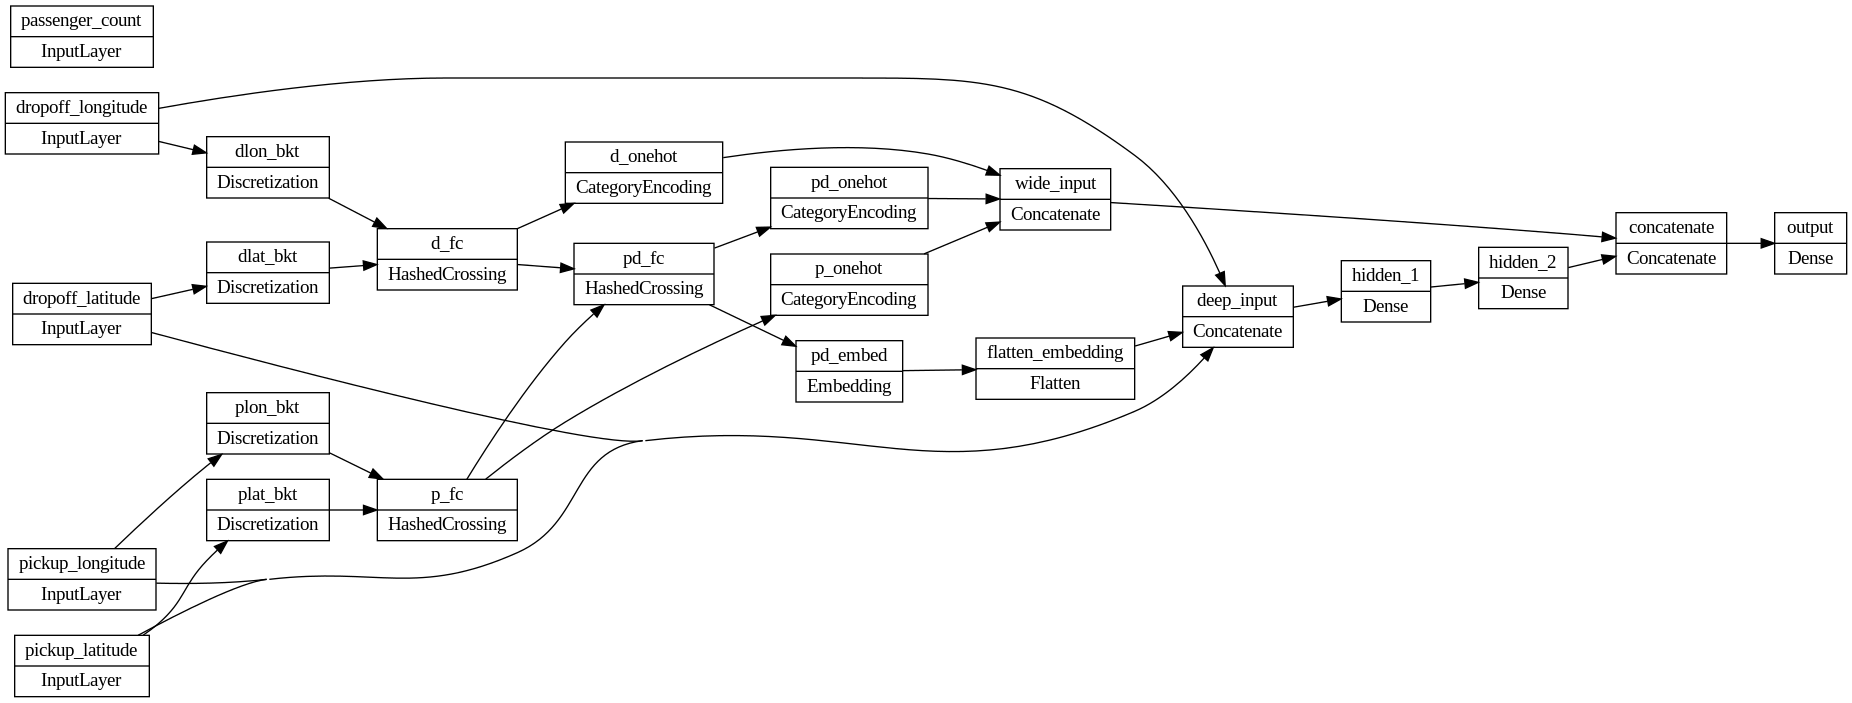

In [23]:
tf.keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

Next, we'll set up our training variables, create our datasets for training and validation, and train our model.

(We refer you the the blog post [ML Design Pattern #3: Virtual Epochs](https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730) for further details on why express the training in terms of `NUM_TRAIN_EXAMPLES` and `NUM_EVALS` and why, in this training code, the number of epochs is really equal to the number of evaluations we perform.)

In [25]:
BATCH_SIZE = 100
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern="../toy_data/taxi-train*", batch_size=BATCH_SIZE, mode="train"
)

evalds = create_dataset(
    pattern="../toy_data/taxi-valid*", batch_size=BATCH_SIZE, mode="eval"
).take(NUM_EVAL_EXAMPLES // 1000)

In [26]:
%%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)

OUTDIR = "./taxi_trained"
shutil.rmtree(path=OUTDIR, ignore_errors=True)  # start fresh each time

# TODO
history = model.fit(
    x=trainds,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EVALS,
    validation_data=evalds,
    callbacks=[TensorBoard(OUTDIR)],
)

Epoch 1/50


10/10 [==============================] - 3s 103ms/step - loss: 187.1262 - rmse: 13.5942 - val_loss: 227.0906 - val_rmse: 14.9977
Epoch 2/50
10/10 [==============================] - 1s 65ms/step - loss: 187.5332 - rmse: 13.5144 - val_loss: 204.9344 - val_rmse: 14.2132
Epoch 3/50
10/10 [==============================] - 1s 65ms/step - loss: 177.0232 - rmse: 13.2675 - val_loss: 179.2346 - val_rmse: 13.2777
Epoch 4/50
10/10 [==============================] - 1s 57ms/step - loss: 121.6396 - rmse: 10.8801 - val_loss: 148.0541 - val_rmse: 12.0625
Epoch 5/50
10/10 [==============================] - 1s 75ms/step - loss: 126.0955 - rmse: 10.9310 - val_loss: 119.1072 - val_rmse: 10.6732
Epoch 6/50
10/10 [==============================] - 1s 62ms/step - loss: 100.8858 - rmse: 9.8886 - val_loss: 104.9567 - val_rmse: 10.1141
Epoch 7/50
10/10 [==============================] - 1s 62ms/step - loss: 80.3410 - rmse: 8.8518 - val_loss: 89.9330 - val_rmse: 9.1973
Epoch 8/50
10/10 [========================

Just as before, we can examine the history to see how the RMSE changes through training on the train set and validation set. 

<Axes: >

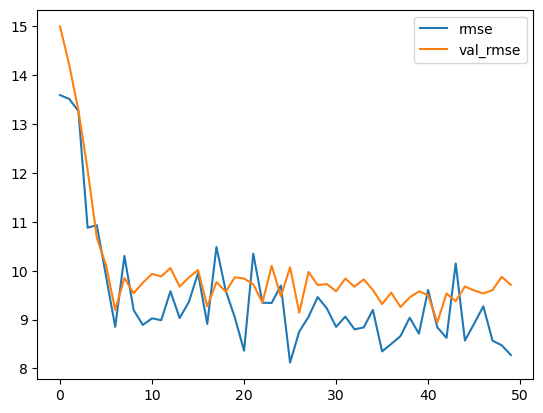

In [27]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License